In [1]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [2]:
import torch

In [3]:
import pandas as pd

## We load the temperature data from the csv file and sort the data into matrices

In [4]:
class read_in_data(object):
    def __init__(self, filename):
        # Open the file
        fid_in = open(filename,"r")
        
        # The first line contains the headers
        dummy = fid_in.readline()
        
        timestamps = []
        depth      = []
        temp       = []
        fluo       = []
        
        # Loop through the file and store the data in the 
        # appropriate lists
        for dummy_line in fid_in:
            dummy_line = dummy_line.strip().split(",")

            date = datetime.strptime(dummy_line[1]+ " " +dummy_line[2], '"%m/%d/%y" "%H:%M:%S"')
            
            
            if dummy_line[3] == 'NA':
                continue
            else:
                timestamps.append(date)

                depth.append(float(dummy_line[3]))

                temp.append(float(dummy_line[4]))
                try:
                    fluo.append(float(dummy_line[5]))
                except:
                    fluo.append(np.nan)
        
        fid_in.close()
        
        self.timestamps = np.array(timestamps)
        self.depth = np.array(depth)
        self.temp = np.array(temp)
        self.fluo = np.array(fluo)
    
        # Convert the timeseries into matrices 
        # It will involve a linear interpolation in the vertical
        self.vertical_consistency(dz = 0.2)
        
    def vertical_consistency(self, dz=0.2):
        
        # Initialize the lists linked to the matrices
        MTemp = []
        MDept = np.arange(0,self.depth.max()+dz,dz)
        MTime = []
        MFluo = []
        
        
        # The end of a profile will be marked by a smaller depth in the next index
        # Here we substract the neighbouring depth and check where it is megative
        # Assuming the first index in the time series is the beginning of a profile
        dep_diff = self.depth[1::] - self.depth[0:-1]
        
        # Where dep_diff <0 That's the end of a profile
        loc_end_prof = np.squeeze(np.where(dep_diff<0.))
  
        # Now we will loop through the indices we created to extract the profiles
        # It seems the profiler stops mid depth in between profiles, we will have 
        # to take this into account
        prof_start = 0
        

        for i in range(0,len(loc_end_prof),1):
            prof_end = loc_end_prof[i]+1
            
            profTime = self.timestamps[prof_start]
            profTemp = self.temp[prof_start:prof_end]
            profDept = self.depth[prof_start:prof_end]
            profFluo = self.fluo[prof_start:prof_end]
        
            # The instances when the profiler is mid depth, the profD should have
            # a length of 1. We don't focus on them, therefore, if we see one, we skip
            if len(profDept) <= 10:
                pass
            else:
                MTime.append(profTime)
                dummy_temp = np.interp(MDept, profDept, profTemp)
                MTemp.append(dummy_temp)
                
                dummy_fluo = np.interp(MDept, profDept, profFluo)
                MFluo.append(dummy_fluo)
            
            prof_start = prof_end # Beginning of next profile
            
        self.MTime = np.array(MTime)
        self.MTemp = np.array(MTemp) # In this configuration MTemp has the following dimensions (Nt, Nz)
        self.MDept = np.array(MDept)
        self.MFluo = np.array(MFluo)

temperature_data = read_in_data("WaterTempData/TeaIsland.csv")
#temperature_data = read_in_data("WaterTempData/AnthonysNose.csv")

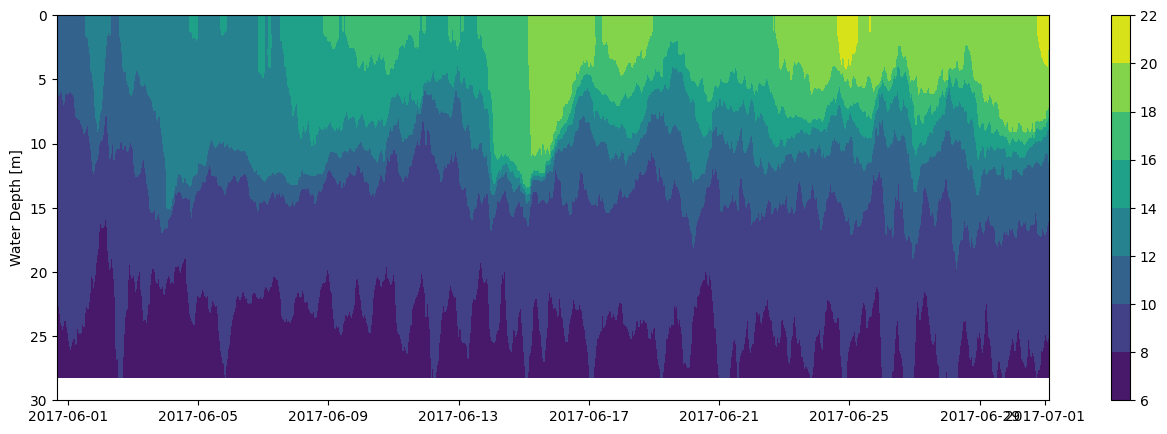

In [5]:
fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
CS = ax.contourf(temperature_data.MTime, temperature_data.MDept, temperature_data.MTemp.T)
CB = plt.colorbar(CS)
ax.set_ylim((30,0))
ax.set_ylabel("Water Depth [m]")
plt.show()

## Using AutoEncoder on the temperature data

In [6]:
# Prepare the loader to generate batches for the learning process
data_to_be_used = np.expand_dims(temperature_data.MTemp,1)
loader = torch.utils.data.DataLoader(dataset = (data_to_be_used - data_to_be_used.mean())/data_to_be_used.std(),
                                     batch_size = 300,
                                     shuffle = True)

In [7]:
import torch.nn.functional as F
## AutoEncoder model
# Creating a PyTorch class
# 28*28 ==> 9 ==> 28*28
class CAE(torch.nn.Module):
    def __init__(self):
        super().__init__()
         
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.conv1 = torch.nn.Conv1d(1, 16, 3)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = torch.nn.Conv1d(16, 4, 3)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = torch.nn.MaxPool1d(2, 2)
         
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = torch.nn.ConvTranspose1d(4, 16, 3, stride=2,dilation=1)
        self.t_conv2 = torch.nn.ConvTranspose1d(16, 1, 3, stride=2, dilation=2, output_padding=1)
 
    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        encoded = F.relu(self.conv1(x))
        #print(encoded.shape)
        encoded = self.pool(encoded)
        #print(encoded.shape)
        # add second hidden layer
        encoded = F.relu(self.conv2(encoded))
        #print(encoded.shape)
        encoded = self.pool(encoded)  # compressed representation
        #print(encoded.shape)
        self.encoded_data = encoded
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        decoded = F.relu(self.t_conv1(encoded))
        #print(decoded.shape)
        # output layer (with sigmoid for scaling from 0 to 1)
        decoded = self.t_conv2(decoded)
        #print(decoded.shape)
        return decoded

In [8]:
# Model Initialization
model = CAE()
 
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
 
# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-1,
                             weight_decay = 1e-8)

In [9]:
epochs = 100
outputs = []
losses = []
for epoch in range(epochs):
    for image in loader:

        # Temperature data are 
        image = image.float()
        
        # Output of Autoencoder
        reconstructed = model(image)
        
        # Calculating the loss function
        loss = loss_function(reconstructed, image)
        
        # The gradients are set to zero,
        # the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Storing the losses in a list for plotting
        losses.append(loss.detach().numpy())
    outputs.append((epochs, image, reconstructed))


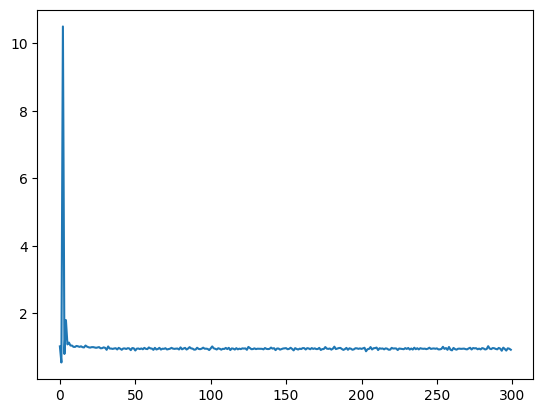

In [10]:
plt.plot(np.array(losses))

## Comparison between modeled and original water temperature

In [11]:
data_processed = (temperature_data.MTemp - temperature_data.MTemp.mean())/temperature_data.MTemp.std()
data_processed = np.expand_dims(data_processed,1)
data_tensor = torch.from_numpy(data_processed)

In [12]:
reconstructed = model(data_tensor.float())
print(reconstructed.shape)
print(temperature_data.MDept.shape)
print(temperature_data.MTime.shape)

torch.Size([728, 1, 142])
(142,)
(728,)


(30.0, 0.0)

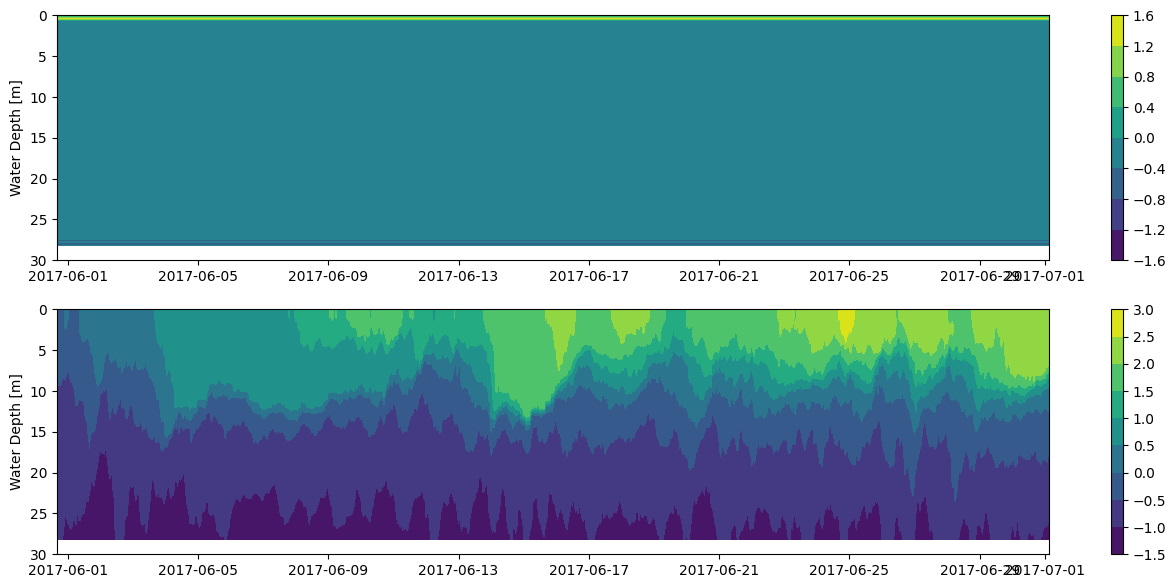

In [13]:
fig = plt.figure(figsize=(16,7))
ax1 = fig.add_subplot(211)
CS1 = ax1.contourf(temperature_data.MTime, temperature_data.MDept,np.squeeze(reconstructed.detach().numpy()).T)
CB1 = plt.colorbar(CS1)
ax1.set_ylabel("Water Depth [m]")
ax1.set_ylim((30,0))

ax2 = fig.add_subplot(212)
CS2 = ax2.contourf(temperature_data.MTime, temperature_data.MDept,np.squeeze(data_processed.T))
CB2 = plt.colorbar(CS2)
ax2.set_ylabel("Water Depth [m]")
ax2.set_ylim((30,0))

### It appears the reconstructed temperature field reproduce somewhat the thermal stratification as well as the temporal changes of the stratification. Which was not reproduced by the regular autoencoder. 
### However, the noise in the reconstructed output indicates something needs to be modified. Interestingly, the noise appear top and bottom of the profile. The interior seems to be substantially less noisy.